    index             category_1                              subcategory  \
0       7  Computers&Accessories                  Accessories&Peripherals   
1       9  Computers&Accessories              ExternalDevices&DataStorage   
2      11  Computers&Accessories                                 Monitors   
3       8  Computers&Accessories                               Components   
4      12  Computers&Accessories                        NetworkingDevices   
5      10  Computers&Accessories                                  Laptops   
6      14  Computers&Accessories                                  Tablets   
7      13  Computers&Accessories                Printers,Inks&Accessories   
8      23            Electronics                       WearableTechnology   
9      18            Electronics           Headphones,Earbuds&Accessories   
10     19            Electronics                                HomeAudio   
11     16            Electronics                      Cameras&Photography   

C:\Users\hridi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hridi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hridi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


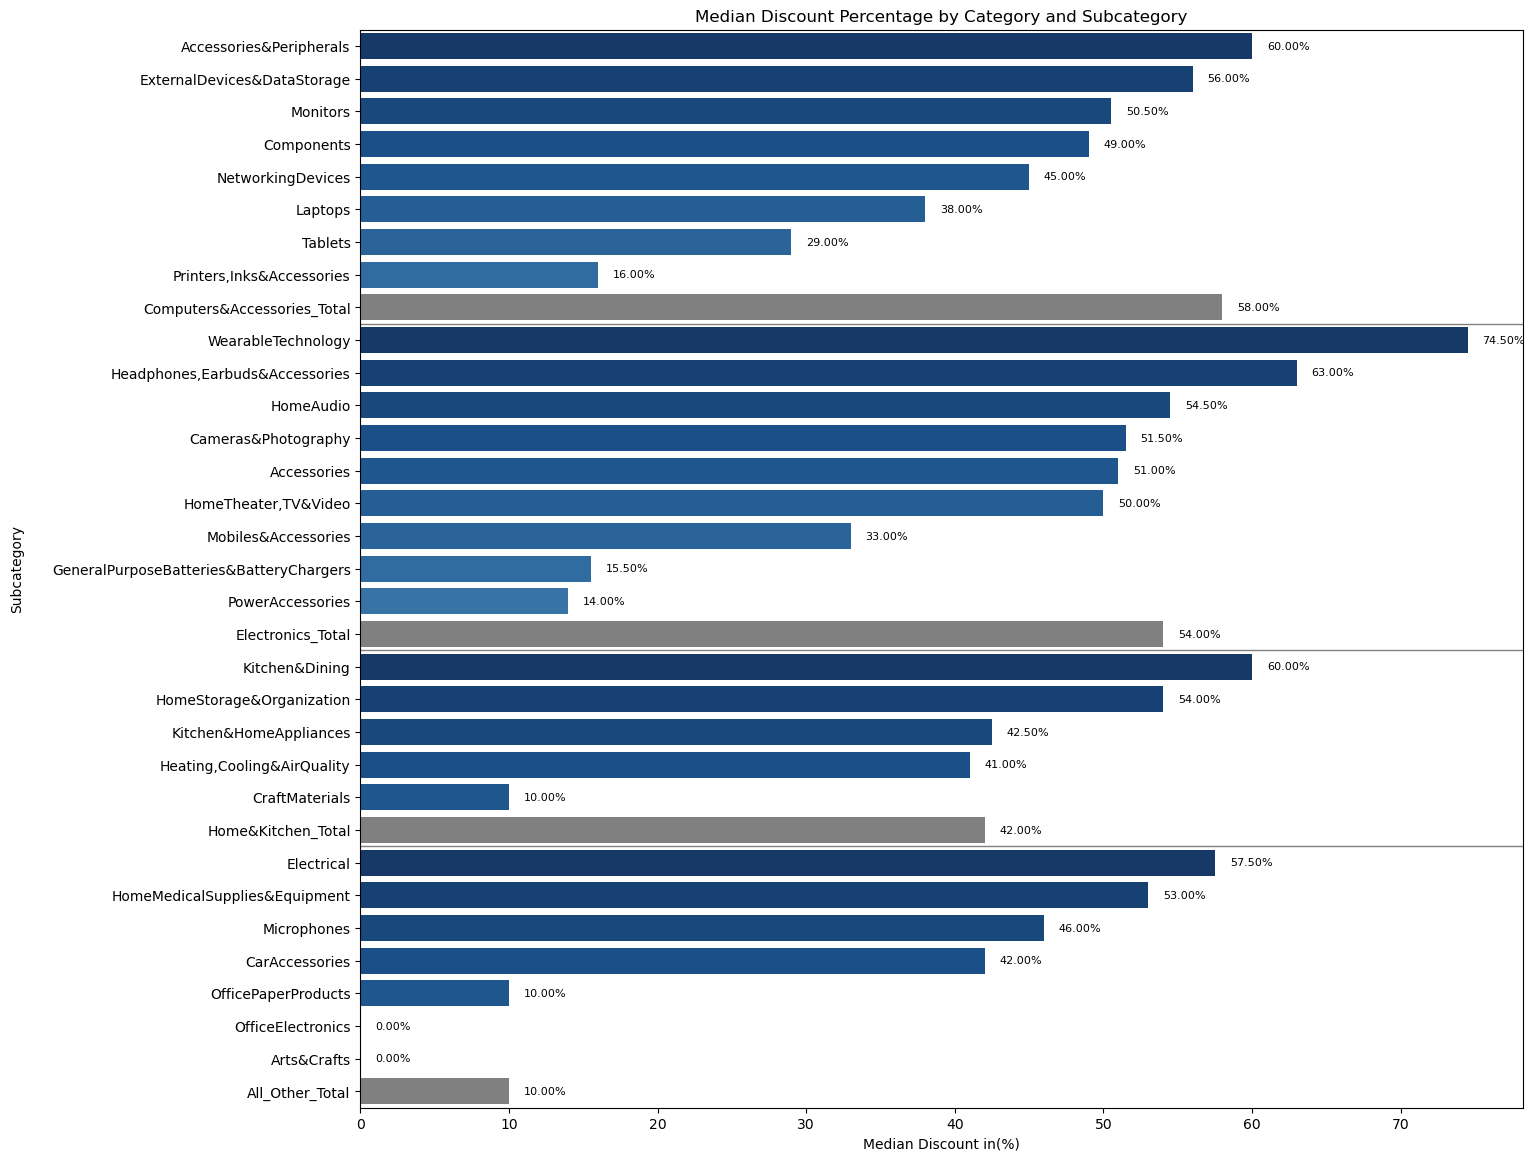

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data and extract main_category and subcategory
data = pd.read_csv('C:/Users/hridi/Downloads/Amazon.csv')
data[['main_category', 'subcategory']] = data['category'].str.split('|', expand=True).iloc[:, :2]

# Define category_1 and convert discount_percentage to float
data['category_1'] = data['main_category'].where(data['main_category'].isin(['Computers&Accessories', 'Electronics', 'Home&Kitchen']), 'All other')
data['discount_percentage'] = data['discount_percentage'].str.rstrip('%').astype(float)

# Group, calculate median discount percentage
median_discount = data.groupby(['category_1', 'subcategory'])['discount_percentage'].median().reset_index()

# Sort the DataFrame based on category orders and reset the index
category_order = ['Computers&Accessories', 'Electronics', 'Home&Kitchen', 'All other']
median_discount['category_1'] = pd.Categorical(median_discount['category_1'], categories=category_order, ordered=True)
median_discount.sort_values(['category_1', 'discount_percentage', 'subcategory'], ascending=[True, False, False], inplace=True)
median_discount.reset_index(drop=False, inplace=True)

# Print the sorted DataFrame with index
print(median_discount)

# Creating a Sorting Index
sort_index_values = []
for index, row in median_discount.iterrows():
    if "All Other" in row["category_1"]:
        sort_index_values.append(index + 100)
    else:
        sort_index_values.append(index)

# Adding a Sort Index Column and Reordering Rows
median_discount["sort_index_values"] = sort_index_values
median_discount_sorted = median_discount.reset_index().set_index('sort_index_values').drop('index', axis=1).sort_index()

# Creating a Totals DataFrame
category_totals = pd.DataFrame(round(data.groupby('category_1')['discount_percentage'].median()).astype('int')).reset_index()
category_totals.insert(loc=1, column='subcategory', value=['All_Other_Total', 'Computers&Accessories_Total', 'Electronics_Total', 'Home&Kitchen_Total'])

# Determining New Index Values
new_index_values = []
for index, row in category_totals.iterrows():
    rslt_df = median_discount_sorted.loc[median_discount_sorted['category_1'] == row['category_1']].tail(1).index[0] + 0.5
    new_index_values.append(rslt_df)

# Inserting New Index and Creating Totals DataFrame
category_totals.insert(loc=0, column='new_index', value=new_index_values)
df_totals = category_totals.reset_index().set_index('new_index').drop('index', axis=1)

# Concatenating DataFrames
final_df = pd.concat([median_discount_sorted, df_totals]).reset_index().set_index('index').sort_index()

# Print the modified DataFrame
print(final_df)


# Identify the index of total bars
total_bars_index = final_df[final_df['subcategory'].isin(['All_Other_Total', 'Computers&Accessories_Total', 'Electronics_Total', 'Home&Kitchen_Total'])].index

# Create a horizontal bar chart with seaborn
plt.figure(figsize=(15, 14))  # Increased the figure size

# Define a custom color palette for each category_1 group
custom_palette = sns.color_palette("Blues_r", n_colors=len(final_df['subcategory']))

# Create a mapping of subcategories to colors based on their sorting order within each category_1 group
color_mapping = {}
for category_1 in category_order:
    subcategories = final_df[final_df['category_1'] == category_1]['subcategory'].unique()
    for i, subcategory in enumerate(subcategories):
        color_mapping[(category_1, subcategory)] = custom_palette[i]   
     
        
# Map the colors to each row in the DataFrame
final_df['color'] = final_df.apply(lambda row: color_mapping[(row['category_1'], row['subcategory'])], axis=1) 
#final_df['color'] = custom_palette  # Default to blue for all subcategories
final_df.loc[final_df.index.isin(total_bars_index), 'color'] = 'grey'  # Change color to grey for total bars


# Use the custom color palette for each bar, considering the custom sorting index
ax = sns.barplot(x='discount_percentage', y='subcategory', data=final_df,
            dodge=True, palette=final_df['color'])  # Use the custom sorting index




# Add separation lines after each category
separation_line_positions = []
current_category = final_df['category_1'][0]
for i, category in enumerate(final_df['category_1']):
    if category != current_category:
        separation_line_positions.append(i)
        current_category = category

# Plot separation lines
for line_position in separation_line_positions:
    plt.axhline(line_position - 0.5, color='grey', linestyle='-', linewidth=1)

# Add median discount percentage as labels after each bar
for i, (value, category) in enumerate(zip(final_df['discount_percentage'], final_df['subcategory'])):
    plt.text(value + 1, i, f'{value:.2f}%', va='center', fontsize=8)  # Decreased the font size

# Add category and subcategory labels
ax.set(ylabel='Subcategory', xlabel='Median Discount in(%)', title='Median Discount Percentage by Category and Subcategory')
ax.yaxis.labelpad = 20

plt.show()
